# Сборный проект №2

## Описание 
***Описание исследования:*** HR-аналитики компании «Работа с заботой» помогают оптимизировать управление персоналом в бизнесе. Они анализируют предоставленные бизнесом данные и предлагают решения, позволяющие избежать финансовых потерь и оттока сотрудников. В этом им помогает применение методов машинного обучения, которые позволяют быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные, содержащие характеристики сотрудников, в том числе уровень их удовлетворенности работой в компании. Этот показатель измеряется на шкале от 0 до 1, где 0 означает полное отсутствие удовлетворенности, а 1 - полную удовлетворенность. Данные получены из форм обратной связи, в которых сотрудники заполняют тест-опросник..

***Цель исследования:*** построить 2 модели машинного обучения и дать рекомендации, направленные на уменьшение оттока сотрудников. 

___
Главные задачи исследования, построить модель, которая сможет: 
 - предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
 - на основе данных заказчика предсказать то, что сотрудник уволится из компании.
 
 
Данное исследование разделим на несколько частей и выделим этапы:

***Изучение общей информации,*** в которой мы загрузим нужные библиотеки и проведем предварительное знакомство с данными 

***Подготовка данных.*** В данной части мы проверим и приведем данные к оптимальным форматам, обрабатаем дубликаты и пропуски.

***Исследовательский анализ и поиск аномалий.*** Проверим все признаки каждого датасета на предмет аномалий и сделаем выводы на основе распределения признаков

***Проведение корреляционного анализа.*** Посмотрим как между собой коррелируют признаки и прорим на мультиколлинеарность

***Построение модели с последубщей оценкой.*** 

***Формирование итогового вывода.***

___
***Исходные данные, которые представлены в датасетах.***
 - id — уникальный идентификатор сотрудника;
 - dept — отдел, в котором работает сотрудник;
 - level — уровень занимаемой должности;
 - workload — уровень загруженности сотрудника;
 - employment_years — длительность работы в компании (в годах);
 - last_year_promo — показывает, было ли повышение за последний год;
 - last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
 - supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
 - salary — ежемесячная зарплата сотрудника;
 - job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.
 - quit - уволился сотрудик или нет

## Загрузка библиотек

In [1]:
!pip install scikit-learn==1.4.0 
!pip install phik
!pip install shap 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import shap
from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder, StandardScaler, 
                                   MinMaxScaler, LabelEncoder, RobustScaler)
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
TEST_SIZE = 0.25


from sklearn.metrics import make_scorer

## Предсказание уровня удовлетворённости сотрудника

### Загрузка данных

In [2]:
train_job_satisfaction_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
test_features = pd.read_csv('/datasets/test_features.csv')
test_target_job_satisfaction_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

In [3]:
train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [4]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [5]:
test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Итог загрузки данных данных:

 - Данные загружены
 - Данные во всех столбцах соответствую описанию
 - Все названия столбцов записаны в оптимальном змеинов формате на латинице

### Предобработка данных 

In [6]:
#создадим функцию для проверки данных в датафреймах на пропуски и дубли
def df_info(df):
    print(df.info())
    print()
    print(f"Количество очевидных дубликатов = {df.duplicated().sum()}")
    print()
    print(f"Количество пропусков = {df.isna().sum()}")    
    
#пайплайн для замены пропущенных значений
imputer_pipe = Pipeline([
    ('SimpleImputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

#### Тренировочная выборка

In [7]:
df_info(train_job_satisfaction_rate)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
None

Количество очевидных дубликатов = 0

Количество пропусков = id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last

In [8]:
#применяем пайплайн
train_job_satisfaction_rate[['dept', 'level']] = imputer_pipe.fit_transform(train_job_satisfaction_rate[['dept', 'level']])

In [9]:
#определим категориальные значения по которым будем искать неочеыидные дубликаты
columns_to_check = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

#в цикле осуществляем поиск
for column in columns_to_check:
    unique_values = train_job_satisfaction_rate[column].unique()
    print(f"Уникальные значения в столбце '{column}': {unique_values}")

Уникальные значения в столбце 'dept': ['sales' 'hr' 'technology' 'purchasing' 'marketing']
Уникальные значения в столбце 'level': ['junior' 'middle' 'sinior']
Уникальные значения в столбце 'workload': ['medium' 'high' 'low']
Уникальные значения в столбце 'last_year_promo': ['no' 'yes']
Уникальные значения в столбце 'last_year_violations': ['no' 'yes']


In [10]:
#исправим опечатку
train_job_satisfaction_rate['level'] = train_job_satisfaction_rate['level'].str.replace('sinior', 'senior')

#### Признаки тестовой выборки

In [11]:
df_info(test_features)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None

Количество очевидных дубликатов = 0

Количество пропусков = id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0

In [12]:
test_features[['dept', 'level']] = imputer_pipe.fit_transform(test_features[['dept', 'level']])

In [13]:
for column in columns_to_check:
    unique_values = test_features[column].unique()
    print(f"Уникальные значения в столбце '{column}': {unique_values}")

Уникальные значения в столбце 'dept': ['marketing' 'hr' 'sales' 'purchasing' 'technology' ' ']
Уникальные значения в столбце 'level': ['junior' 'middle' 'sinior']
Уникальные значения в столбце 'workload': ['medium' 'low' 'high' ' ']
Уникальные значения в столбце 'last_year_promo': ['no' 'yes']
Уникальные значения в столбце 'last_year_violations': ['no' 'yes']


In [14]:
#исправляем опечатку
test_features['level'] = test_features['level'].str.replace('sinior', 'senior')

#### Целевой признак тестовой выборки

In [15]:
df_info(test_target_job_satisfaction_rate)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
None

Количество очевидных дубликатов = 0

Количество пропусков = id                       0
job_satisfaction_rate    0
dtype: int64


Итог загрузки предобработки данных:
 - Типы данных в корректном формате
 - Явных дубликатов не обнаружено
 - В ```train_job_satisfaction_rate``` и ```test_features``` исправлены опечатки в столбце 'level'
 - С помощью пайплайна заполнены пропуски частым значением 

### Исследовательский анализ

In [16]:
#пишем функцию для отображения гарфиков в зависимоти от типа 
def plot_data_visualization(df, col_name):
    if col_name != 'id':
        if df[col_name].dtype in ['int64', 'float64']:
            fig, ax = plt.subplots(figsize=(16, 5))
            sns.countplot(x=df[col_name], ax=ax)
            ax.set_title(f"Распределение значений признака {col_name}")
            ax.set_xlabel(col_name)
            ax.set_ylabel('Количество')
            ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
            plt.tight_layout()
            plt.show()
        else:
            plt.figure(figsize=(16, 5))
            counts = df[col_name].value_counts()
            plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
            plt.title(f"Соотношение {col_name}")
            plt.axis('equal')
            plt.show()
    
    
#создадим функцию для выведения первых строк датафрейма и описания количественных показателей
def explore_df(df):
    display(df.head())
    print()
    display(df.describe())

#### Тренировочная выборка

In [17]:
explore_df(train_job_satisfaction_rate)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


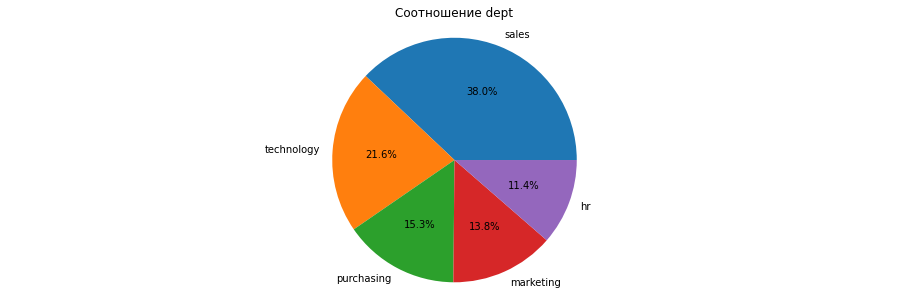

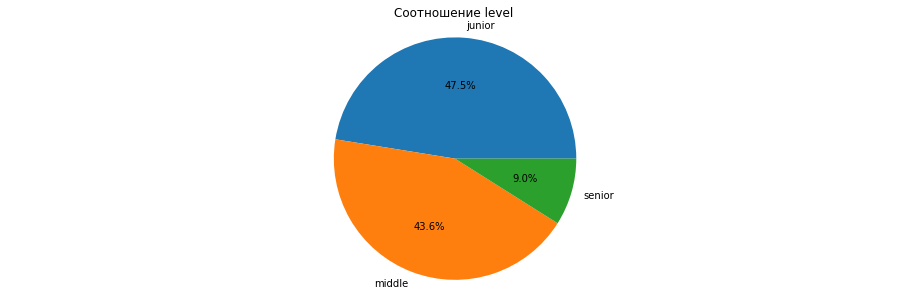

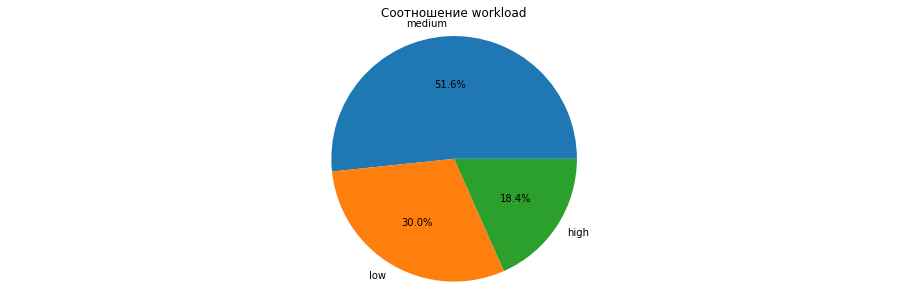

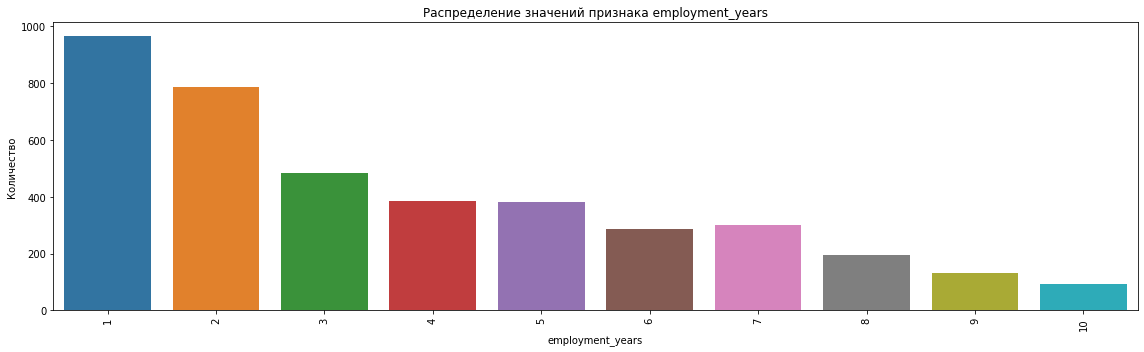

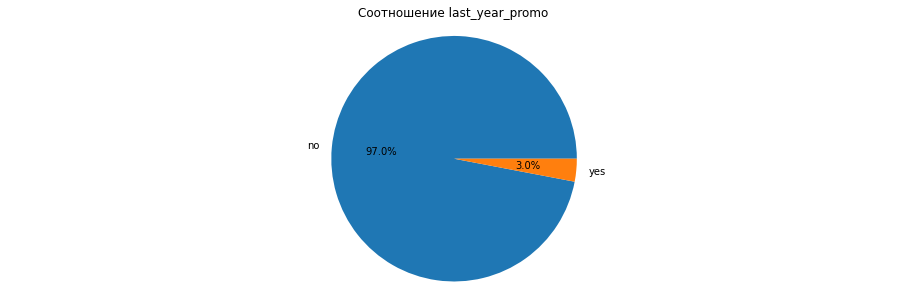

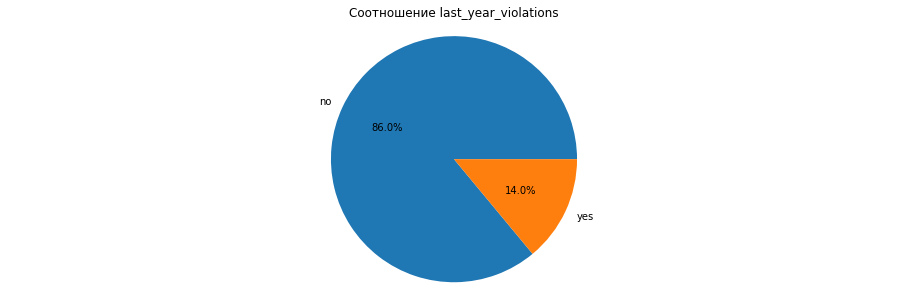

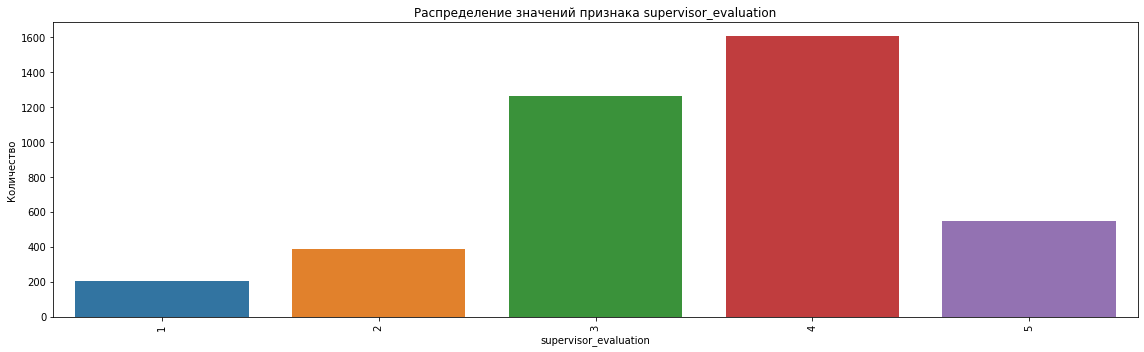

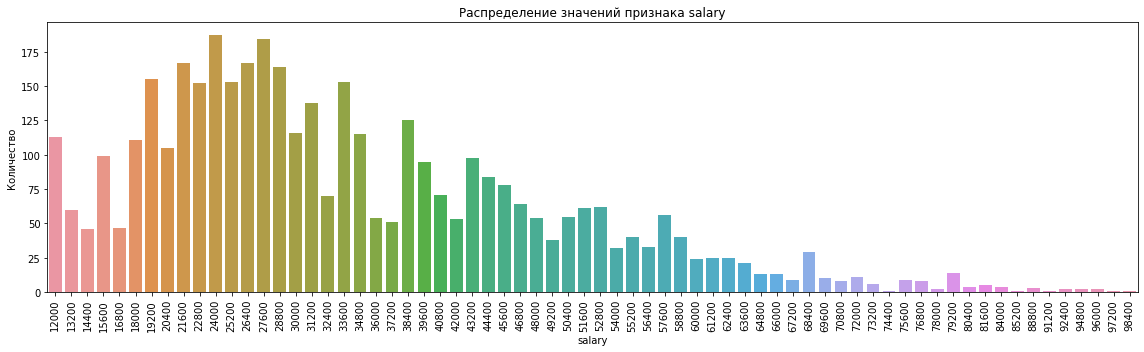

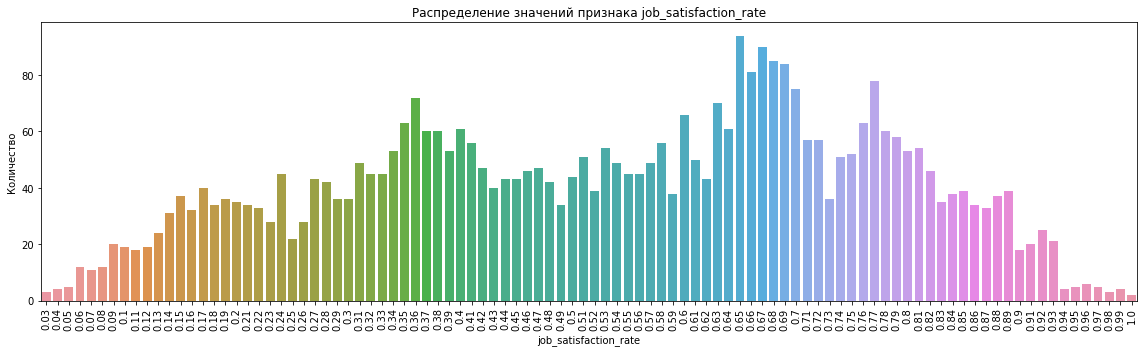

In [18]:
for column in train_job_satisfaction_rate.columns:
    plot_data_visualization(train_job_satisfaction_rate, column)

Итоги анализа тренировочной выборки:
 - В компании преобладает количество персонала из отедла продаж
 - Больше всего сотрудников имеют позицию Junior, меньше всего Senior
 - Половина сотрудников имеют средний уровень загруденности
 - Большинство сотрудников в компании новички, которые работают не более 3х лет
 - Только 3% сотрудников были продвинуты по должности за последний год 
 - 14% сотрудников нарушили трудовой договор за последний год
 - самая частая оценка, которую дает руководитель сотрудник - 4, присутствует и оценка 1, у меньшинства сотрудников
 - Подавляющее количество сотрудников имеют зарплату в диапазоне с 20000 до ~ 39000
 - Удовлетворенность сотрудников (целевой признак) распределился с 2 пиками: оценки ~0.38 и ~0.68

#### Признаки тестовой выборки

In [19]:
explore_df(test_features)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


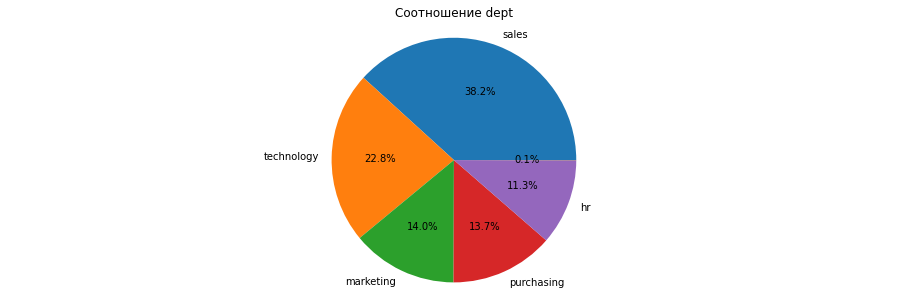

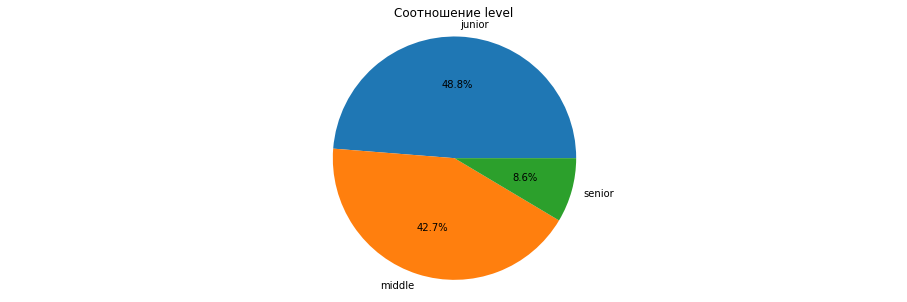

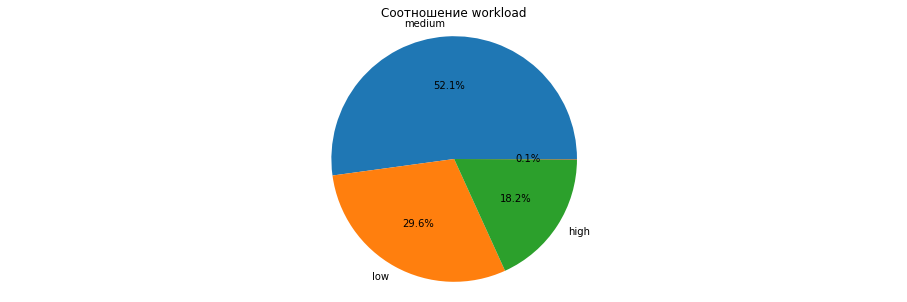

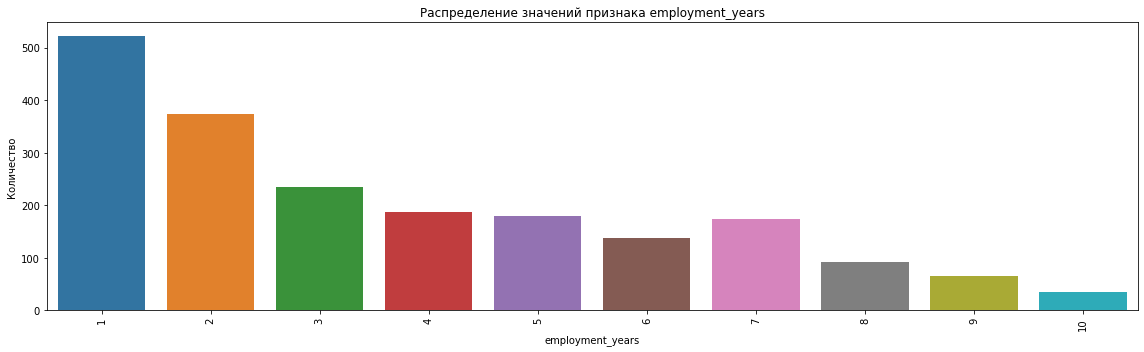

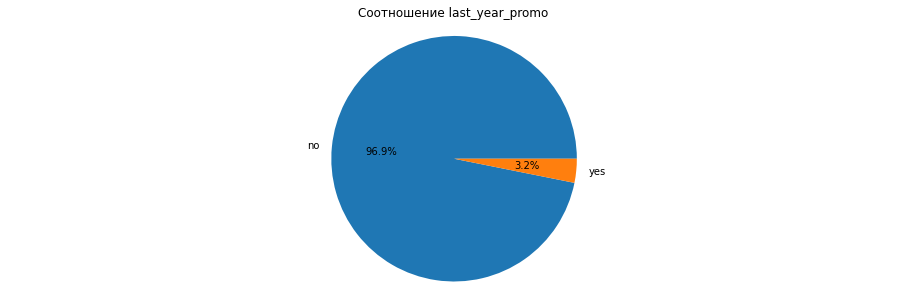

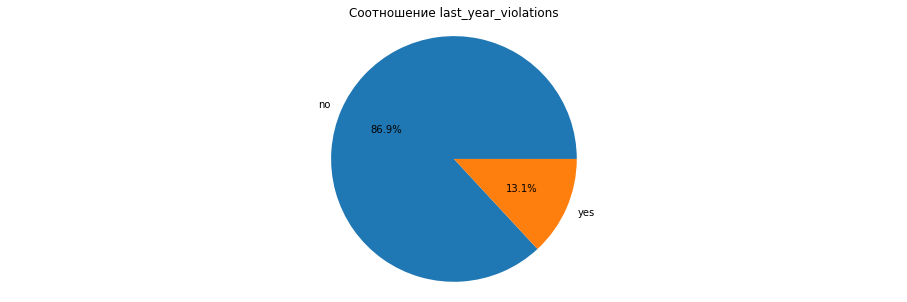

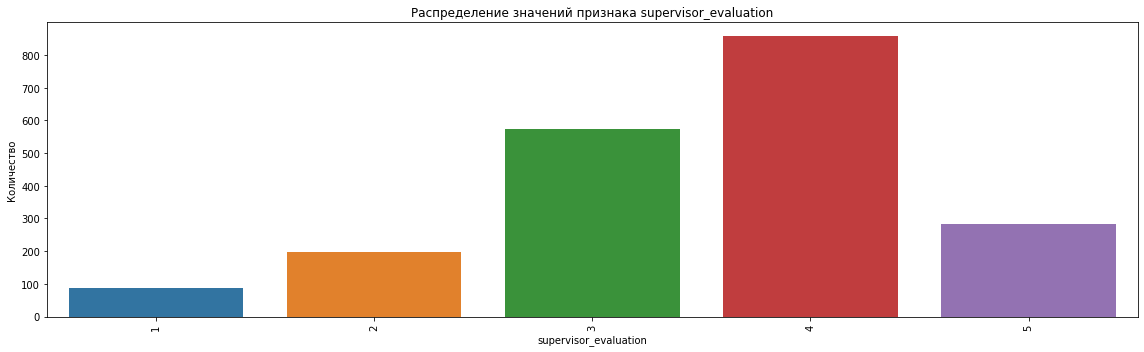

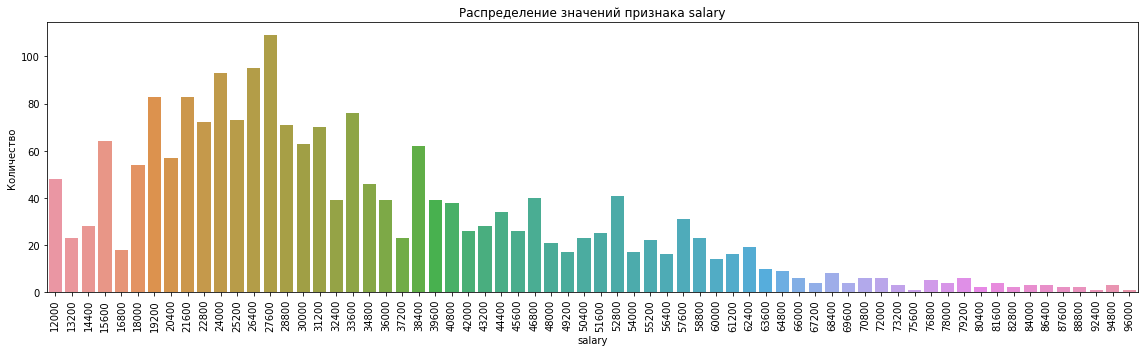

In [20]:
for column in test_features:
    plot_data_visualization(test_features, column)

Признаки соотнесены примерно также, как и в тренировочной выборке

#### Целевой признак тестовой выборки

In [21]:
explore_df(test_target_job_satisfaction_rate)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


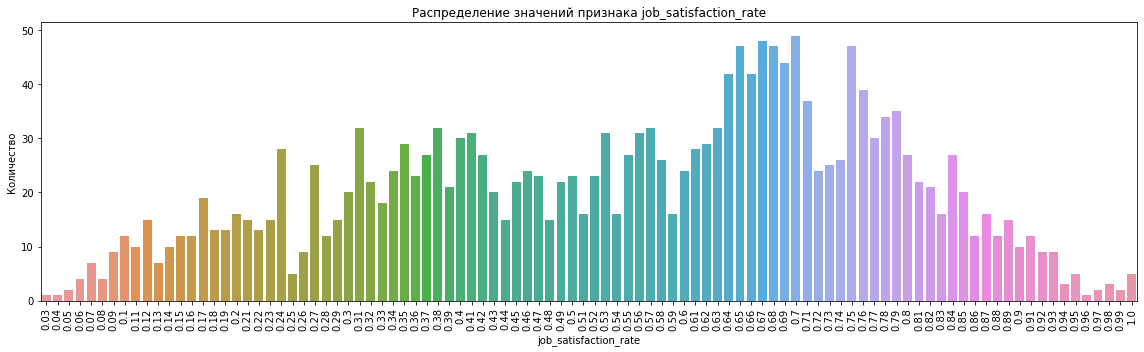

In [22]:
for column in test_target_job_satisfaction_rate:
    plot_data_visualization(test_target_job_satisfaction_rate, column)

Такое же соотношение, как и в тренировочной выборке

#### Корреляция

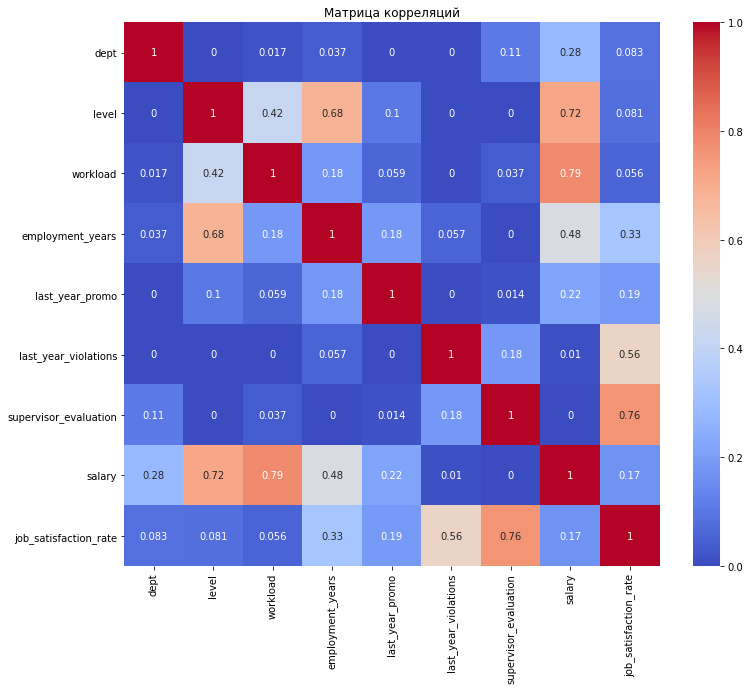

In [23]:
interval_cols = ['job_satisfaction_rate', 'salary']

phik_matrix = train_job_satisfaction_rate.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)
plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляций')
plt.show()

Итоги исследовательского анализа:
 - Мультиколлинеарность отсутствует
 - Целевой признак имеет 2 пиковых значения, напоминает нормальное распределение 
 - Из матрицы корреляции видно: 
   - Зарплата хорошо коррелирует с уровенем загрузки и позицией, что логично
   - Стаж сотрудника в компании влияет на его должность
   - Оценка удовлетворения работой зависит от оценки руководства и были ли нарушения трудового договора за последний год

### Обучение и оценка модели

In [24]:
def smape(y_true, y_pred):
    return 100 * np.mean(np.abs(y_pred - y_true) / ((np.abs(y_pred) + np.abs(y_true))/2))

smape_score = make_scorer(smape, greater_is_better=False)

In [25]:
#соединим тестовые выборки
test = test_features.merge(test_target_job_satisfaction_rate, on='id')

#убираем лишнее
train_job_satisfaction_rate = train_job_satisfaction_rate.set_index('id')

#выделяем признак в выборках
X_train = train_job_satisfaction_rate.drop(['job_satisfaction_rate'], axis=1)
y_train = train_job_satisfaction_rate['job_satisfaction_rate']

X_test = test.drop(['job_satisfaction_rate', 'id'], axis=1)
y_test = test['job_satisfaction_rate']

#проверим
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4000, 8)
(4000,)
(2000, 8)
(2000,)


In [26]:
#поделим показатели на количественные и качественные 
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

#создаем пайплайн 
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ])

ord_pipe = Pipeline([
    ('ord', OrdinalEncoder(
        categories=[
            ['junior', 'middle', 'senior'],
            ['low', 'medium', 'high']
        ],
        handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

#задаем параметры
param_grid = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    },
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(10, 30),
        'models__max_features': range(10, 30)
    }
]

#ищем лучшие параметры
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring= smape_score,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

#обучим модель
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Метрика на кросс-валидации:', randomized_search.best_score_ *(-1))

#предскажем тестовую выборку
y_test_pred = randomized_search.predict(X_test)

#оценим 
print(f"Метрика SMAPE на тестовой выборке: {smape(y_test, y_test_pred)}")

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

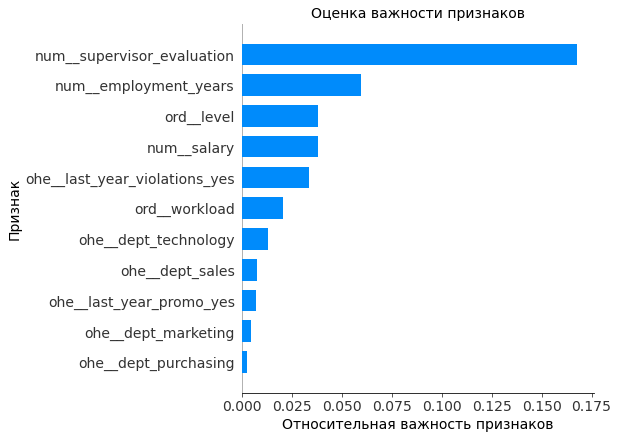

In [27]:
#применим модель
X_train_transformed = randomized_search.best_estimator_.named_steps['preprocessor'].fit_transform(X_train)
X_test_transformed = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_test)

explainer = shap.TreeExplainer(randomized_search.best_estimator_.named_steps['models'])
shap_values = explainer.shap_values(X_test_transformed)

#возвращаем названия призанков
feature_names = randomized_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

#рисуем график важности
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, plot_type="bar", max_display=12, show=False)

fig, ax = plt.gcf(), plt.gca()

ax.tick_params(labelsize=14)
ax.set_xlabel("Относительная важность признаков", fontsize=14)
ax.set_ylabel("Признак", fontsize=14)
ax.set_title('Оценка важности признаков', fontsize=14)
plt.show()

Итог обучения первой модели:
 - Найдена лучшая модель для предсказания уровня удовлетворенности сотрудника: DecisionTreeRegressor с параметрами (max_depth=13, max_features=16)
  - Показатель SMAPE ~ 14.2, что указывает на хорошую работу нашей модели
  - На целевой признак, исходя из предсказаний модели больше всего влият оценка качества сотрудника, что подтвердилось с этапа корреляции. На втором по значимости месте идет время отработанное в компании 
  - Была создана и модель линейной регрессии, но она показала себя хуже 

## Предсказание увольнения сотрудника из компании

### Загрузка данных

In [28]:
train_quit = pd.read_csv('/datasets/train_quit.csv')
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')

In [29]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [30]:
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Итог загрузки данных данных:
 - Данные для второй задачи загружены 
 - Данные во всех столбцах соответствую описанию
 - Название стобцов в корректном формате
 - Для тестовый выборки с входными признаками будем использовать уже обрботанный датасет ```test_features```

### Предобаботка данных 

#### Тренировочная выборка

In [31]:
df_info(train_quit)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
None

Количество очевидных дубликатов = 0

Количество пропусков = id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
l

In [32]:
#определим категориальные значения по которым будем искать дубликаты
columns_to_check = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']

for column in columns_to_check:
    unique_values = train_quit[column].unique()
    print(f"Уникальные значения в столбце '{column}': {unique_values}")

Уникальные значения в столбце 'dept': ['sales' 'purchasing' 'marketing' 'technology' 'hr']
Уникальные значения в столбце 'level': ['middle' 'junior' 'sinior']
Уникальные значения в столбце 'workload': ['high' 'medium' 'low']
Уникальные значения в столбце 'last_year_promo': ['no' 'yes']
Уникальные значения в столбце 'last_year_violations': ['no' 'yes']
Уникальные значения в столбце 'quit': ['no' 'yes']


In [33]:
#исправим опечатку
train_quit['level'] = train_quit['level'].str.replace('sinior', 'senior')

#### Целевой признак тестовой выборки

In [34]:
df_info(test_target_quit)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None

Количество очевидных дубликатов = 0

Количество пропусков = id      0
quit    0
dtype: int64


Итог загрузки предобработки данных:
 - Типы данных в корректном формате
 - Явных дубликатов не обнаружено
 - В ```train_quit``` исправлены опечатки в столбце 'level'

### Исследовательский анализ данных

#### Тренировочная выборка

In [35]:
explore_df(train_quit)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


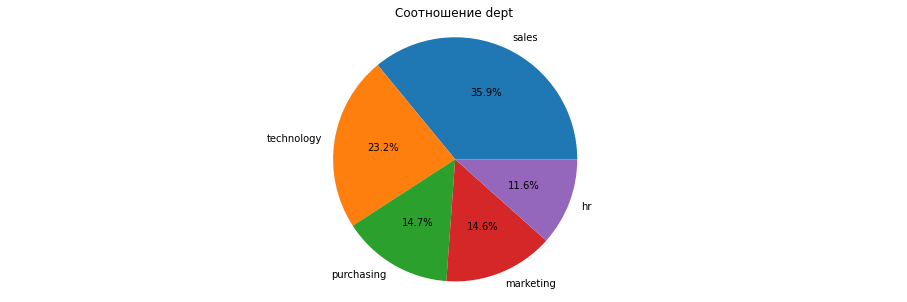

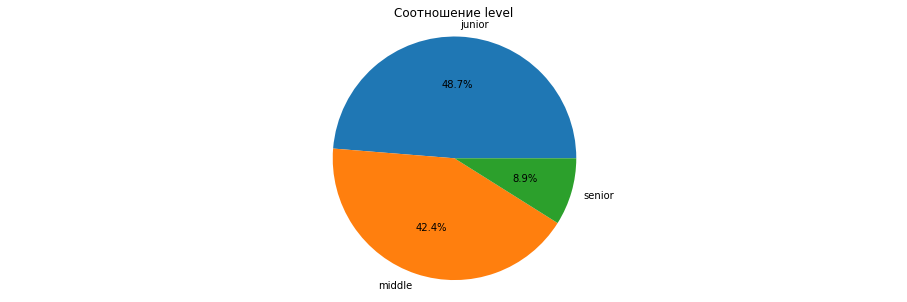

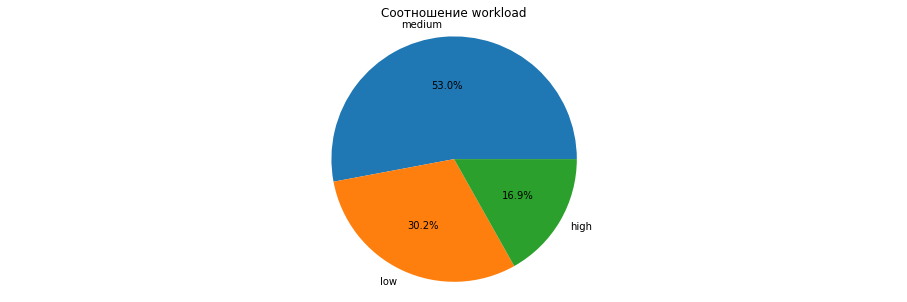

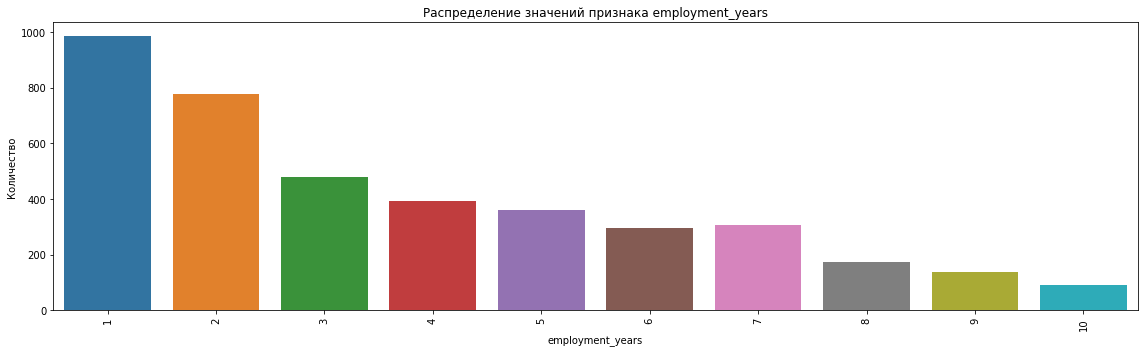

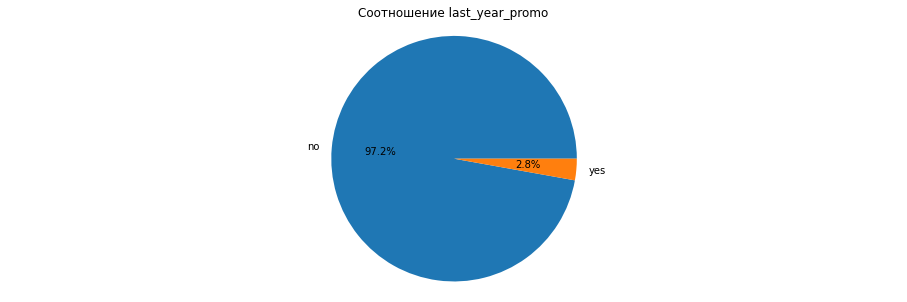

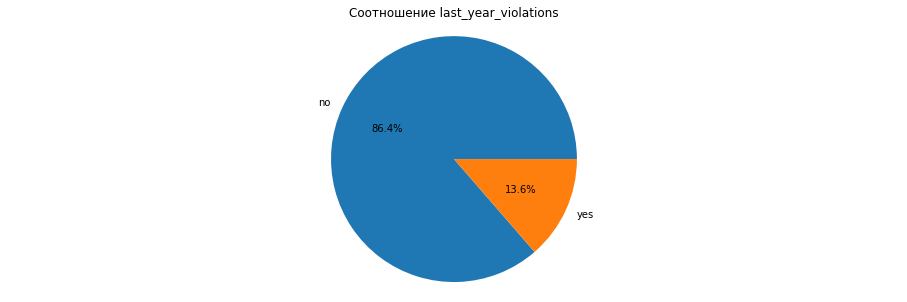

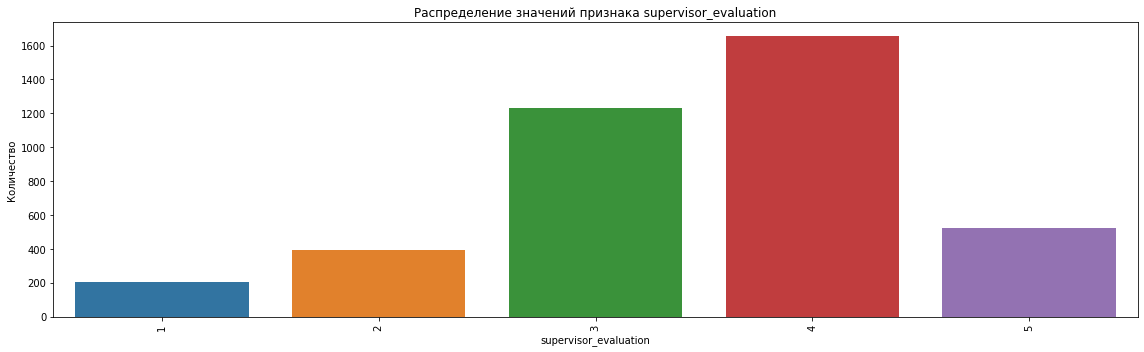

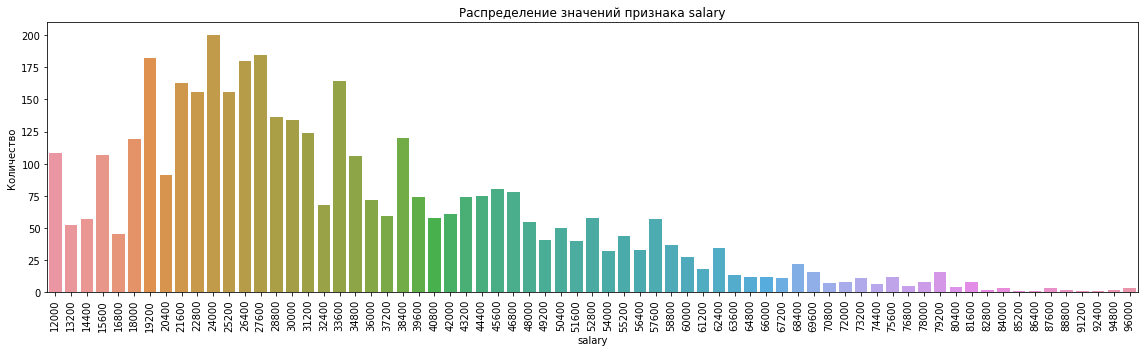

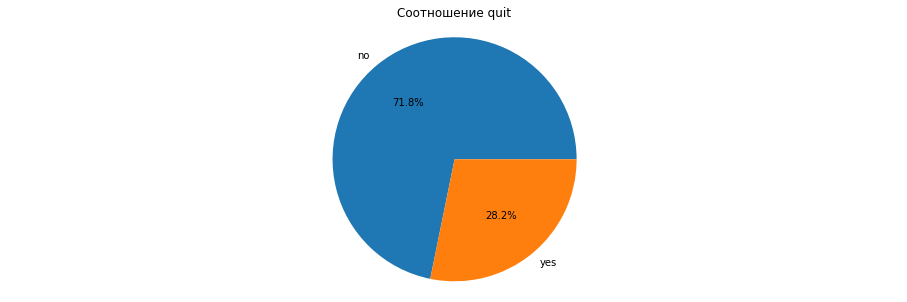

In [36]:
for column in train_quit.columns:
    plot_data_visualization(train_quit, column)

Итоги анализа тренировочной выборки:
 - В компании преобладает количество персонала из отедла продаж, меньше всего в HR отделе 
 - Примерно равное соотношение Junior и Middle позиций, меньше всего Senior
 - Половина сотрудников имеют средний уровень загруденности
 - Большинство сотрудников в компании новички, которые работают не более 3х лет
 - Только 2.8% сотрудников были продвинуты по должности за последний год 
 - 13.6% сотрудников нарушили трудовой договор за последний год
 - самая частая оценка, которую дает руководитель сотрудник - 4, присутствует и оценка 1, у меньшинства сотрудников
 - Подавляющее количество сотрудников имеют зарплату в диапазоне с 20000 до ~ 39000
 - 28.2% сотрудников уволились, целевой показатель имеет явный дисбаланс 
 
Датасет с данным практически идентиче датасету из первой задачи

#### Целевой признак тестовой выборки

In [37]:
test_target_quit['quit'].unique()

array(['yes', 'no'], dtype=object)

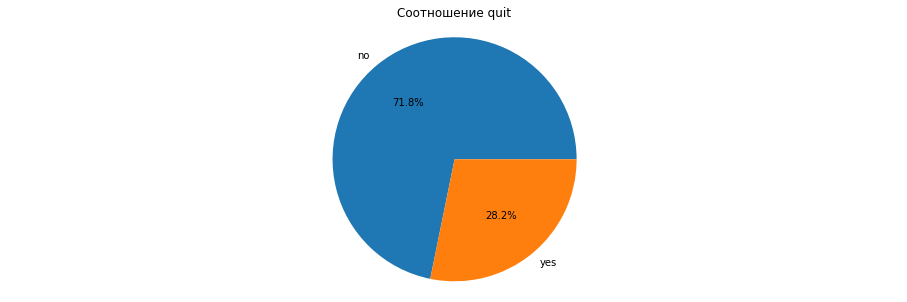

In [38]:
for column in test_target_quit.columns:
    plot_data_visualization(test_target_quit, column)

Итоги анализа для признака тестовой выборки:
    - Дисбаланс целевого признака
    - Соотношения уволившихся сотрудников равно этому же признаку из тренировочной выборки (28.2%)

#### Корреляция

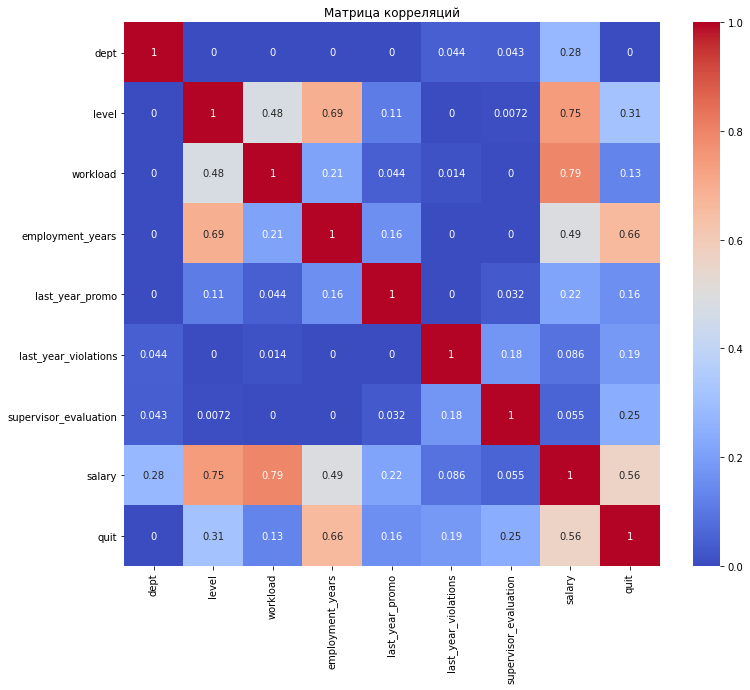

In [39]:
interval_cols = ['job_satisfaction_rate', 'salary']

phik_matrix = train_quit.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)
plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляций')
plt.show()

In [40]:
#разделим на 2 выборки
df_quit = train_quit[train_quit['quit'] == "yes"]
df_not_quit = train_quit[train_quit['quit'] == "no"]

for df_name, df in [("уволившихся", df_quit), ("не уволившихся", df_not_quit)]:
    print(f"\nСтатистика для {df_name} сотрудников:")
    print(f"Средняя зарплата: {df['salary'].mean():.2f}")
    print(f"Уровень с наибольшей долей: {df['level'].value_counts().index[0]}")
    print(f"Наиболее распространенная загруженность: {df['workload'].value_counts().index[0]}")
    print(f"Средний стаж: {df['employment_years'].mean():.2f} лет")


Статистика для уволившихся сотрудников:
Средняя зарплата: 23885.11
Уровень с наибольшей долей: junior
Наиболее распространенная загруженность: low
Средний стаж: 1.84 лет

Статистика для не уволившихся сотрудников:
Средняя зарплата: 37702.23
Уровень с наибольшей долей: middle
Наиболее распространенная загруженность: medium
Средний стаж: 4.43 лет


In [41]:
#доли уволившихся сотрудников по признакам
for col in ['dept', 'level', 'workload']:
    print(' ')
    for value, group in df_quit.groupby(col):
        value_count = train_quit[col].value_counts()[value]
        value_quit_rate = len(group) / value_count
        print(f"{value}: {value_quit_rate:.2%} ({len(group)} из {value_count},"
              f" {len(group) / len(df_quit):.2%} от всех уволившихся)")

 
hr: 25.00% (116 из 464, 10.28% от всех уволившихся)
marketing: 28.01% (163 из 582, 14.45% от всех уволившихся)
purchasing: 28.23% (166 из 588, 14.72% от всех уволившихся)
sales: 28.30% (407 из 1438, 36.08% от всех уволившихся)
technology: 29.74% (276 из 928, 24.47% от всех уволившихся)
 
junior: 51.46% (1003 из 1949, 88.92% от всех уволившихся)
middle: 6.38% (108 из 1694, 9.57% от всех уволившихся)
senior: 4.76% (17 из 357, 1.51% от всех уволившихся)
 
high: 17.95% (121 из 674, 10.73% от всех уволившихся)
low: 42.96% (519 из 1208, 46.01% от всех уволившихся)
medium: 23.04% (488 из 2118, 43.26% от всех уволившихся)


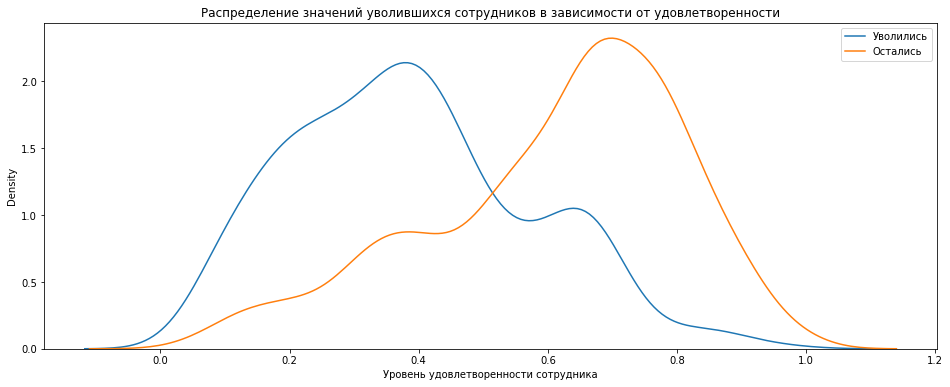

In [42]:
target_sat = test_target_quit.merge(test_target_job_satisfaction_rate, on='id')

# Визуализация распределений job_satisfaction_rate
fig, ax = plt.subplots(figsize=(16,6))

# Линейные графики
sns.kdeplot(data=target_sat[target_sat['quit'] == 'yes'], x="job_satisfaction_rate", label="Уволились")
sns.kdeplot(data=target_sat[target_sat['quit'] == 'no'], x="job_satisfaction_rate", label="Остались")

ax.set_xlabel("Уровень удовлетворенности сотрудника")
ax.set_title("Распределение значений уволившихся сотрудников в зависимости от удовлетворенности")
ax.legend()
plt.show()

Из гарфика видно, что на самом деле присутствует взаимосвязь между удовлетворенностью сотрудника его увольнением. Люди, которые больше оценили уровень удовлетворенности компанией чаще остаются сотрудниками компании, чем те, кто оценивает это показатель низко. Можно сделать вывод о взаимосвязи, в дальшейшем добавим в выборку для предсказаний 

Итоги исследовательского анализа:
 - Мультиколлинеарность отсутствует
 - Целевой признак имеет явный дисбаланс
 - Из матрицы корреляции видно: 
   - Зарплата хорошо коррелирует с уровенем загрузки и позицией, что логично
   - Стаж сотрудника в компании влияет на его должность
   - Оценка удовлетворения работой зависит от оценки руководства и были ли нарушения трудового договора за последний год
  - Чем выше сотник оченивает удовлетворенность от работы в компании, тем выше вероятность, что он не будет увольняться 
  
___
Портрет уволившегося сотрудника: 
 - Средняя зарплата: 23885.11
 - Уровень с наибольшей долей: junior
 - Наиболее распространенная загруженность: low
 - Средний стаж: 1.84 лет

Выделим, что характерно для сотрудников, которые остались в компании в с равнии с ушедшими:
 - Заработная плата на ~15000 больше
 - Находятся не на стартовой позиции, а на middle
 - Сильнее оценивают уровень загруженности
 - Имеет стаж, в среднем в 2 раза больше
 
Доля уволившихся сотрудников по отделам, позициям и уровню нагрузки:

 - hr: 25.00% (116 из 464, 10.28% от всех уволившихся)
 - marketing: 28.01% (163 из 582, 14.45% от всех уволившихся)
 - purchasing: 28.23% (166 из 588, 14.72% от всех уволившихся)
 - sales: 28.30% (407 из 1438, 36.08% от всех уволившихся)
 - technology: 29.74% (276 из 928, 24.47% от всех уволившихся)
___ 
 - junior: 51.46% (1003 из 1949, 88.92% от всех уволившихся)
 - middle: 6.38% (108 из 1694, 9.57% от всех уволившихся)
 - senior: 4.76% (17 из 357, 1.51% от всех уволившихся)
___ 
 - high: 17.95% (121 из 674, 10.73% от всех уволившихся)
 - low: 42.96% (519 из 1208, 46.01% от всех уволившихся)
 - medium: 23.04% (488 из 2118, 43.26% от всех уволившихся)
 
Видим:
 - Больше всего сотрудников в отделе продаж, там же и больше всего процент уволившихся
 - Если сотрудник продвигается по карьерной лестнице, то шанс, что он останется в компании кратно поднимается
 - Количество уволившихся распределено примерно одинаково между теми, кто оценивает нагрузки слабо и средне. При этом сотрудники с высокой нагрузкой имеют хорошую вероятность остаться, можно связать с повышенной зарплатой и обязанностями.

### Обучение и оценка модели

In [43]:
#применим нашу модель и добавим новый признак
test_features['job_satisfaction_rate_pred'] = randomized_search.best_estimator_.predict(X_test)
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate_pred
0,485046,marketing,junior,medium,2,no,no,5,28800,0.872000
1,686555,hr,junior,medium,1,no,no,4,30000,0.668621
2,467458,sales,middle,low,5,no,no,4,19200,0.657143
3,418655,sales,middle,low,6,no,no,4,19200,0.655000
4,789145,hr,middle,medium,5,no,no,5,40800,0.824127


In [44]:
train_quit['job_satisfaction_rate_pred'] = randomized_search.best_estimator_.predict(train_quit.drop(['quit'], axis=1))
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_pred
0,723290,sales,middle,high,2,no,no,4,54000,no,0.635385
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.815938
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.364091
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.380000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.690000


In [45]:
#объединим целевой признак с тестовой выборкой 
test_features = test_features.merge(test_target_quit, on='id')

#убираем лишнее
test_features = test_features.set_index('id')
train_quit = train_quit.set_index('id')

In [46]:
#выделяем признак в выборках
X_train = train_quit.drop(['quit'], axis=1)
y_train = train_quit['quit']

X_test = test_features.drop(['quit'], axis=1)
y_test = test_features['quit']

#проверим
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4000, 9)
(4000,)
(2000, 9)
(2000,)


In [47]:
#признак бинарный, категориальный, закодируем показатели
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [48]:
ohe_columns = ['last_year_violations', 'last_year_promo', 'dept']
ord_columns = ['level', 'workload' ]
num_columns = ['salary', 'employment_years', 'supervisor_evaluation', 'job_satisfaction_rate_pred'] 

ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ])

ord_pipe = Pipeline([
    ('ord', OrdinalEncoder(
        categories=[
            ['junior', 'middle', 'senior'],
            ['low', 'medium', 'high']
        ],
        handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

#задаем параметры
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,8),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

#ищем лучшие параметры
randomized_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
#обучим модель
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

#оценим по метрике
y_test_proba = randomized_search.predict_proba(X_test)[:,1]
print(f"Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_proba)}")

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_violations',
                                                   'last_year_promo', 'dept']),
                                                 ('ord',
                            

Итог обучения второй модели:
 - Найдена лучшая модель для предсказания увольнения сотрудника KNeighborsClassifier(n_neighbors=7)
 - Показатель ROC-AUC ~ 0,915, что указывает на хорошую работу нашей модели
 - Были проверены 2 другие модели: логистическая регрессия и метод ближайших соседей, но показали меньший уровень метрики

## Общий вывод и рекомендации

Выполнены поставленные задачи для исследования:
 - Разработана модель для предсказания удовлетворенности сотрудником компании
 - Разработана модель, предсказывающая увольнение персонала 
 
___
Для проведения исследования нам передали датасеты с:
 - Тренировочными выборками
 - Тестовой выборкой
 - Целевым показателем

___

Проведена предобработка датасетов:
 - Исправлены опечатки
 - С помощью пайплайна заменены пропуски
 - Датасеты проверены на наличие:
   - Дубликатов
   - Пропусков
   - Корректного типа данных

В общем, датасеты были предоставлены в очень хорошем качестве

___

Чтобы найти лучшую модель для решения задачи был проведен исследовательский анализ и объединены датасеты в тестовых выборках с целевым признаком, аномалии не были обнаружены, проведен корреляционный анализ, мультиколлинеарность не была найдена, добавлен новый признак в тестовую выборку.

Лучшей моделью для предсказания удовлетворенности сотрудниками (задача регрессии), оказалась DecisionTreeRegressor с параметрами (max_depth=13, max_features=16). Для оценки была создана метрика SMAPE, ее уровень применимо к нашей модели ~14.2. Дополнительно обучена модель:
 - LinearRegression

Для второй задачи на прогнозирование увольнения (задача классификации), лучшей показала себя модель  KNeighborsClassifier с параметром (n_neighbors=7). Метрика ROC-AUC ~ 0.915. Дополнительно обучены модели:
 - DecisionTreeClassifier
 - LogisticRegression

___

Наиболее важными признаками согласно модели, влияющих на удовлетворенность от компании:
 - Уровень оценки от руководства 
 - Стаж работы в компании
 
___
Рекомендации: 
 - В отделе продаж больше всего сотрудников, но и текучка там выше. Возможно системы поощрения за выполнения плана или другая мотивация подтолкнет реже увольняться.
 - Стоит обратить внимание на повышение уровня удовлетворенности сотрудника - это сильно сказывается на то уволится он или нет
 - Люди, перешедшие на позицию middle оказываются более лояльными к компании и дольше задерживаются в ней. Стоит рассмотреть способы обучения и ускоренного продвижения сотрудников
 - Сотрудники с средней занятостью реже увольняются, скорее всего тут корреляция с зарплатой - чем больше работаешь, тем больше получаешь. Возможно стоит рассмотреть варианты расширения сервиса, возможно для подроботок и реализации работника в рамках компании